In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error


In [9]:
df = pd.read_csv('./ipl.csv')
df.head()

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222


In [10]:
cols_to_drop = ['mid','batsman','bowler','striker','non-striker']
df.drop(cols_to_drop,axis=1,inplace=True)
df.head()

,date,venue,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.1,1,0,222
1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.2,1,0,222
2,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.2,2,0,222
3,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.3,2,0,222
4,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.4,2,0,222


In [11]:
df['date'] = df['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))


# we have to remove temporary teams or the teams which are not available now
consistent_teams = ['Chennai Super Kings', 'Delhi Daredevils', 
                    'Kings XI Punjab', 'Kolkata Knight Riders', 
                    'Mumbai Indians', 'Rajasthan Royals', 
                    'Royal Challengers Bangalore', 'Sunrisers Hyderabad']

df = df[(df['bat_team'].isin(consistent_teams)) & (df['bowl_team'].isin(consistent_teams))]


# we don't want first five overs data
df = df[df['overs']>=5.0]

df.head()

,date,venue,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
32,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,61,0,5.1,59,0,222
33,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.2,59,1,222
34,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.3,59,1,222
35,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.4,59,1,222
36,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.5,58,1,222


In [12]:
df['venue'].unique()


array(['M Chinnaswamy Stadium',
       'Punjab Cricket Association Stadium, Mohali', 'Feroz Shah Kotla',
       'Wankhede Stadium', 'Sawai Mansingh Stadium',
       'MA Chidambaram Stadium, Chepauk', 'Eden Gardens',
       'Dr DY Patil Sports Academy', 'Newlands', "St George's Park",
       'Kingsmead', 'SuperSport Park', 'Buffalo Park',
       'New Wanderers Stadium', 'De Beers Diamond Oval',
       'OUTsurance Oval', 'Brabourne Stadium',
       'Sardar Patel Stadium, Motera',
       'Himachal Pradesh Cricket Association Stadium',
       'Subrata Roy Sahara Stadium',
       'Rajiv Gandhi International Stadium, Uppal',
       'Shaheed Veer Narayan Singh International Stadium',
       'JSCA International Stadium Complex', 'Sheikh Zayed Stadium',
       'Sharjah Cricket Stadium', 'Dubai International Cricket Stadium',
       'Barabati Stadium', 'Maharashtra Cricket Association Stadium',
       'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
       'Punjab Cricket Association IS Bi

In [13]:
def f(x):
    if x=='M Chinnaswamy Stadium':
        return 'M Chinnaswamy Stadium, Bangalore'
    elif x=='Feroz Shah Kotla':
        return 'Feroz Shah Kotla, Delhi'
    elif x=='Wankhede Stadium':
        return 'Wankhede Stadium, Mumbai'
    elif x=='Sawai Mansingh Stadium':
        return 'Sawai Mansingh Stadium, Jaipur'
    elif x=='Eden Gardens':
        return 'Eden Gardens, Kolkata'
    elif x=='Dr DY Patil Sports Academy':
        return 'Dr DY Patil Sports Academy, Mumbai'
    elif x=='Himachal Pradesh Cricket Association Stadium':
        return 'Himachal Pradesh Cricket Association Stadium, Dharamshala'
    elif x=='Subrata Roy Sahara Stadium':
        return 'Maharashtra Cricket Association Stadium, Pune'
    elif x=='Shaheed Veer Narayan Singh International Stadium':
        return 'Raipur International Cricket Stadium, Raipur'
    elif x=='JSCA International Stadium Complex':
        return 'JSCA International Stadium Complex, Ranchi'
    elif x=='Maharashtra Cricket Association Stadium':
        return 'Maharashtra Cricket Association Stadium, Pune'
    elif x=='Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium':
        return 'ACA-VDCA Stadium, Visakhapatnam'
    elif x=='Punjab Cricket Association IS Bindra Stadium, Mohali':
        return 'Punjab Cricket Association Stadium, Mohali'
    elif x=='Holkar Cricket Stadium':
        return 'Holkar Cricket Stadium, Indore'
    elif x=='Sheikh Zayed Stadium':
        return 'Sheikh Zayed Stadium, Abu-Dhabi'
    elif x=='Sharjah Cricket Stadium':
        return 'Sharjah Cricket Stadium, Sharjah'
    elif x=='Dubai International Cricket Stadium':
        return 'Dubai International Cricket Stadium, Dubai'
    elif x=='Barabati Stadium':
        return 'Barabati Stadium, Cuttack'
    else:
        return x

ignored_stadiums = ['Newlands', "St George's Park",
                    'Kingsmead', 'SuperSport Park', 'Buffalo Park',
                    'New Wanderers Stadium', 'De Beers Diamond Oval',
                    'OUTsurance Oval', 'Brabourne Stadium']

df = df[True^(df['venue'].isin(ignored_stadiums))]
df['venue'] = df['venue'].apply(f)
df.head()

,date,venue,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
32,2008-04-18,"M Chinnaswamy Stadium, Bangalore",Kolkata Knight Riders,Royal Challengers Bangalore,61,0,5.1,59,0,222
33,2008-04-18,"M Chinnaswamy Stadium, Bangalore",Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.2,59,1,222
34,2008-04-18,"M Chinnaswamy Stadium, Bangalore",Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.3,59,1,222
35,2008-04-18,"M Chinnaswamy Stadium, Bangalore",Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.4,59,1,222
36,2008-04-18,"M Chinnaswamy Stadium, Bangalore",Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.5,58,1,222


In [14]:
df_new = pd.get_dummies(data=df,columns=['venue','bat_team','bowl_team'])
df_new.head()

,date,runs,wickets,overs,runs_last_5,wickets_last_5,total,"venue_ACA-VDCA Stadium, Visakhapatnam","venue_Barabati Stadium, Cuttack","venue_Dr DY Patil Sports Academy, Mumbai",...,bat_team_Royal Challengers Bangalore,bat_team_Sunrisers Hyderabad,bowl_team_Chennai Super Kings,bowl_team_Delhi Daredevils,bowl_team_Kings XI Punjab,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad
32,2008-04-18,61,0,5.1,59,0,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
33,2008-04-18,61,1,5.2,59,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
34,2008-04-18,61,1,5.3,59,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
35,2008-04-18,61,1,5.4,59,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
36,2008-04-18,61,1,5.5,58,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [15]:
df_new.columns

Index(['date', 'runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5',
       'total', 'venue_ACA-VDCA Stadium, Visakhapatnam',
       'venue_Barabati Stadium, Cuttack',
       'venue_Dr DY Patil Sports Academy, Mumbai',
       'venue_Dubai International Cricket Stadium, Dubai',
       'venue_Eden Gardens, Kolkata', 'venue_Feroz Shah Kotla, Delhi',
       'venue_Himachal Pradesh Cricket Association Stadium, Dharamshala',
       'venue_Holkar Cricket Stadium, Indore',
       'venue_JSCA International Stadium Complex, Ranchi',
       'venue_M Chinnaswamy Stadium, Bangalore',
       'venue_MA Chidambaram Stadium, Chepauk',
       'venue_Maharashtra Cricket Association Stadium, Pune',
       'venue_Punjab Cricket Association Stadium, Mohali',
       'venue_Raipur International Cricket Stadium, Raipur',
       'venue_Rajiv Gandhi International Stadium, Uppal',
       'venue_Sardar Patel Stadium, Motera',
       'venue_Sawai Mansingh Stadium, Jaipur',
       'venue_Sharjah Cricket Stadi

In [16]:
df_new.reset_index(inplace=True)
df_new.drop('index',inplace=True,axis=1)
df_new

,date,runs,wickets,overs,runs_last_5,wickets_last_5,total,"venue_ACA-VDCA Stadium, Visakhapatnam","venue_Barabati Stadium, Cuttack","venue_Dr DY Patil Sports Academy, Mumbai",...,bat_team_Royal Challengers Bangalore,bat_team_Sunrisers Hyderabad,bowl_team_Chennai Super Kings,bowl_team_Delhi Daredevils,bowl_team_Kings XI Punjab,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad
0,2008-04-18,61,0,5.1,59,0,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2008-04-18,61,1,5.2,59,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2008-04-18,61,1,5.3,59,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2008-04-18,61,1,5.4,59,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2008-04-18,61,1,5.5,58,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35646,2017-05-19,106,9,18.1,29,4,107,0,0,0,...,0,0,0,0,0,0,1,0,0,0
35647,2017-05-19,107,9,18.2,29,4,107,0,0,0,...,0,0,0,0,0,0,1,0,0,0
35648,2017-05-19,107,9,18.3,28,4,107,0,0,0,...,0,0,0,0,0,0,1,0,0,0
35649,2017-05-19,107,9,18.4,24,4,107,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [17]:
scaler = StandardScaler()

scaled_cols = scaler.fit_transform(df_new[['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5']])
scaled_cols = pd.DataFrame(scaled_cols,columns=['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5'])

df_new.drop(['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5'],axis=1,inplace=True)
df_new = pd.concat([df_new,scaled_cols],axis=1)

df_new.head()

,date,total,"venue_ACA-VDCA Stadium, Visakhapatnam","venue_Barabati Stadium, Cuttack","venue_Dr DY Patil Sports Academy, Mumbai","venue_Dubai International Cricket Stadium, Dubai","venue_Eden Gardens, Kolkata","venue_Feroz Shah Kotla, Delhi","venue_Himachal Pradesh Cricket Association Stadium, Dharamshala","venue_Holkar Cricket Stadium, Indore",...,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad,runs,wickets,overs,runs_last_5,wickets_last_5
0,2008-04-18,222,0,0,0,0,0,0,0,0,...,0,0,0,1,0,-0.832372,-1.590613,-1.667664,1.713851,-1.233715
1,2008-04-18,222,0,0,0,0,0,0,0,0,...,0,0,0,1,0,-0.832372,-1.062418,-1.644520,1.713851,-0.294064
2,2008-04-18,222,0,0,0,0,0,0,0,0,...,0,0,0,1,0,-0.832372,-1.062418,-1.621376,1.713851,-0.294064
3,2008-04-18,222,0,0,0,0,0,0,0,0,...,0,0,0,1,0,-0.832372,-1.062418,-1.598232,1.713851,-0.294064
4,2008-04-18,222,0,0,0,0,0,0,0,0,...,0,0,0,1,0,-0.832372,-1.062418,-1.575088,1.627459,-0.294064


In [18]:
X_train = df_new.drop('total',axis=1)[df_new['date'].dt.year<=2016]
X_test = df_new.drop('total',axis=1)[df_new['date'].dt.year>=2017]

X_train.drop('date',inplace=True,axis=1)
X_test.drop('date',inplace=True,axis=1)


y_train = df_new[df_new['date'].dt.year<=2016]['total'].values
y_test = df_new[df_new['date'].dt.year>=2017]['total'].values

In [19]:
X_train

,"venue_ACA-VDCA Stadium, Visakhapatnam","venue_Barabati Stadium, Cuttack","venue_Dr DY Patil Sports Academy, Mumbai","venue_Dubai International Cricket Stadium, Dubai","venue_Eden Gardens, Kolkata","venue_Feroz Shah Kotla, Delhi","venue_Himachal Pradesh Cricket Association Stadium, Dharamshala","venue_Holkar Cricket Stadium, Indore","venue_JSCA International Stadium Complex, Ranchi","venue_M Chinnaswamy Stadium, Bangalore",...,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad,runs,wickets,overs,runs_last_5,wickets_last_5
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,-0.832372,-1.590613,-1.667664,1.713851,-1.233715
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,-0.832372,-1.062418,-1.644520,1.713851,-0.294064
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,-0.832372,-1.062418,-1.621376,1.713851,-0.294064
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,-0.832372,-1.062418,-1.598232,1.713851,-0.294064
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,-0.832372,-1.062418,-1.575088,1.627459,-0.294064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32868,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,2.388520,2.106747,1.595629,1.281891,2.524889
32869,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,2.533823,2.106747,1.618773,1.454675,2.524889
32870,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,2.558041,2.106747,1.641917,1.454675,2.524889
32871,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,2.582258,2.106747,1.665060,1.541067,2.524889


{'alpha': 35}
-347.14763514988374


MAE: 12.363044348487998
MSE: 266.54295334707894
RMSE: 16.326143247781424


r2 score of ridge : 0.7369307878485571


C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

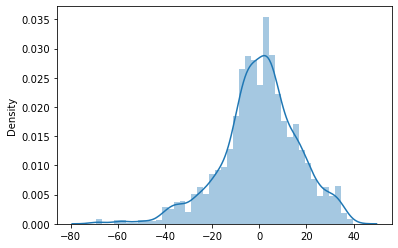

In [20]:
ridge = Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
ridge_regressor = RandomizedSearchCV(ridge,parameters,cv=10,scoring='neg_mean_squared_error')
ridge_regressor.fit(X_train,y_train)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

print('\n')

# IPL Score Prediction
prediction_r = ridge_regressor.predict(X_test)
print('MAE:', mean_absolute_error(y_test, prediction_r))
print('MSE:', mean_squared_error(y_test, prediction_r))
print('RMSE:', np.sqrt(mean_squared_error(y_test, prediction_r)))

print('\n')

print(f'r2 score of ridge : {r2_score(y_test,prediction_r)}')

sns.distplot(y_test-prediction_r)

In [21]:
joblib.dump(ridge_regressor,'iplmodel_ridge.sav')


['iplmodel_ridge.sav']